In [1]:
from brian2 import *
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [3]:
%matplotlib notebook

# Define Connectivity

<IPython.core.display.Javascript object>


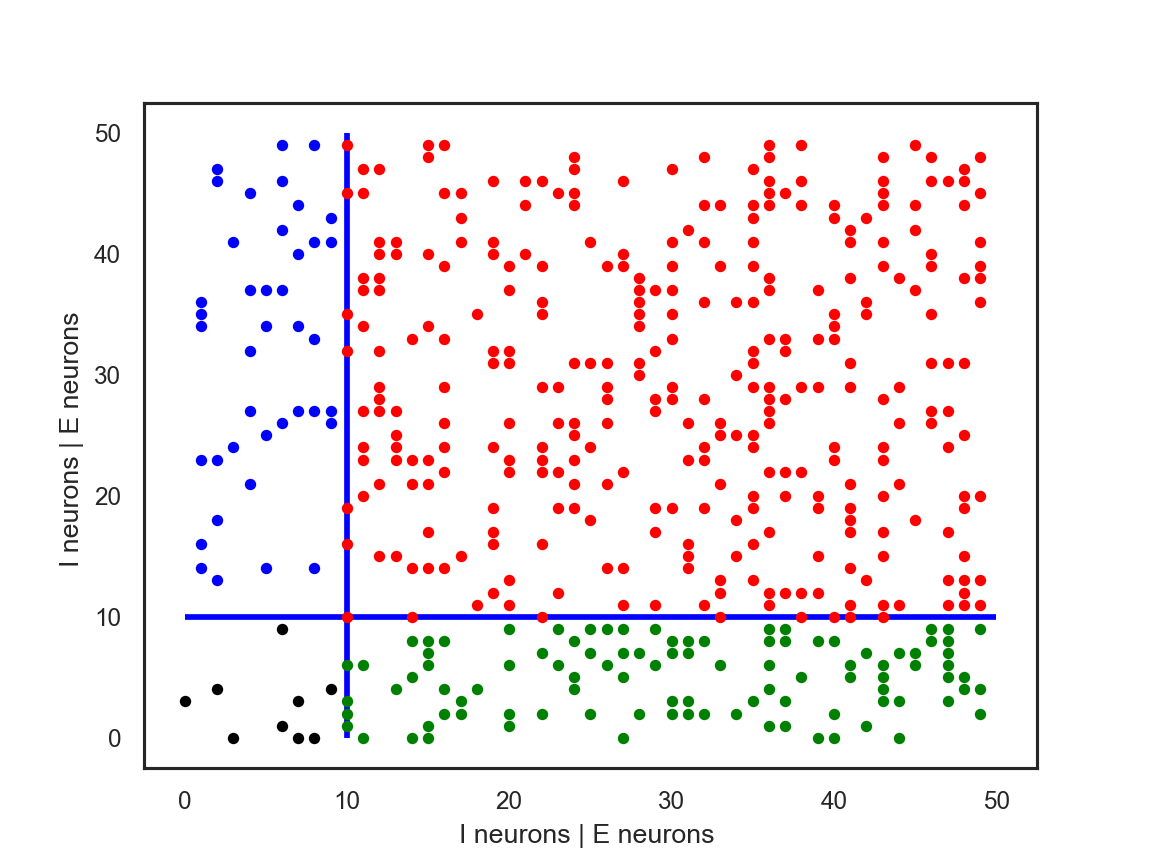

Text(0,0.5,'I neurons | E neurons ')

In [56]:
### Get some connectivity 
presynI_postE = []
presynI_postI = []
presynE_postE = []
presynE_postI = []

### Probability connectivities b/w inhibitory excitatory neurons 
JII = 0.1; 
JIE = 0.1; 
JEI = 0.2; 
JEE = 0.2; 

### Total number of neurons in the network 
nneurons = 50

### Total number of inhibitory neurons
nneuronsI = nneurons/5

### Define connectivity: 
for i in range(nneurons): 
    for j in range(nneurons): 
        
        ### First 1/5th of presynaptic cells are inhibitory 
        if i < nneuronsI and j < nneuronsI:
            
            if np.random.rand() < JII:
                presynI_postI.append([i, j])
        
        elif i < nneuronsI and j >= nneuronsI: 
            
            if np.random.rand() < JIE:
                presynI_postE.append([i, j - nneuronsI])
                
        elif i >= nneuronsI and j < nneuronsI: 
            
            if np.random.rand() < JEI:
                presynE_postI.append([i - nneuronsI, j])
                
        elif i >= nneuronsI and j >= nneuronsI:
            
            if np.random.rand() < JEE:
                presynE_postE.append([i  - nneuronsI, j - nneuronsI])           
            
#### Plot Cx matrix #### 
presynI_postI = np.vstack((presynI_postI)).astype(int)
presynI_postE = np.vstack((presynI_postE)).astype(int)
presynE_postI = np.vstack((presynE_postI)).astype(int)
presynE_postE = np.vstack((presynE_postE)).astype(int)


f, ax = plt.subplots()
ax.plot(presynI_postI[:, 0], presynI_postI[:, 1], 'k.')
ax.plot(presynI_postE[:, 0], presynI_postE[:, 1] + nneuronsI, 'b.')
ax.plot(presynE_postI[:, 0]+ nneuronsI, presynE_postI[:, 1], 'g.')
ax.plot(presynE_postE[:, 0]+ nneuronsI, presynE_postE[:, 1]+ nneuronsI, 'r.')

ax.hlines(nneuronsI, 0, nneurons, 'b')
ax.vlines(nneuronsI, 0, nneurons, 'b')
ax.set_xlabel('I neurons | E neurons ')
ax.set_ylabel('I neurons | E neurons ')

# Use this connectivity in a network

Simulate a network using the defined connectivity above. Two decisions were made already -- 1) using alpha funciton synapse dynamics -- allow for onset time and peak value specification. 2) Current based synapses. Values within the network have references; 

In [57]:
def PSP2wt(alpha_tau=1.7, wt = 0.14):
    t = np.arange(300)/10.
    w_ = wt*np.exp(1)
    return w_/alpha_tau

In [58]:
def simulate_network(presynI_postE, presynI_postI, presynE_postE, presynE_postI, 
                     n_neurons, nneuronsI, background_drive_nS_E = 5, seed_num = None):
    
    start_scope()
    # ###########################################
    # Defining network model parameters
    # ###########################################
    ### Background drive 
    ### See this ref for how bg drive gets added: https://brian2.readthedocs.io/en/2.0rc3/advanced/random.html
    ### Also this example: https://brian2.readthedocs.io/en/stable/examples/frompapers.Diesmann_et_al_1999.html
    #drive = background_drive_mV*mV/ms;
    driveE = background_drive_nS_E*nS/ms;
    noiseE = 10
    
    onset_tau_ampa = 1.*ms   # Glutamatergic synaptic onset time; matched to amp onset time (1.0 ms) 
                             # from Brunel & Wang (2003)
        
    onset_tau_gaba = 1.5*ms  # GABAergic synaptic onset time constant; made a bit longer than 
                             # reported onset time in order to give a longer decay tail (5ms decay compared to 
                             # ampa decay = 2ms)
    
    #### Weights -- matched to peak g_syn*s_peak frmo brunel & wang; 
    ampa_wt = PSP2wt(alpha_tau=onset_tau_ampa/ms, wt = 1*nS)
    gaba_wt = PSP2wt(alpha_tau=onset_tau_gaba/ms, wt = 6*nS)
    
        
    # ###########################################
    # Neuron model
    # ###########################################

    gl = 10.0*nsiemens   # Leak conductance --> 1/R
    Vr = -70*mV          # Resting potential
    Vt = -55.*mV         # Spiking threshold
    
    Ir = -80*mV          # Inhibitory reversal potential
    Er = 0*mV            # Excitatory reverse potetntial 
    
    ### Membrane time constant; 
    E_mts = 20*ms;
    I_mts = 10*ms
    
    
    E_eqs_neurons='''
    dv/dt=((Vr - v) + (g_ampa*(Er - v) + g_gaba*(Ir - v))/gl)/E_mts : volt 
    dg_ampa/dt = (q_ampa-g_ampa)/onset_tau_ampa : siemens
    dq_ampa/dt = (-q_ampa)/onset_tau_ampa + driveE + (noiseE*1*nS/ms**0.5)*xi: siemens 
    
    dg_gaba/dt = (q_gaba-g_gaba)/onset_tau_gaba : siemens
    dq_gaba/dt = (-q_gaba)/onset_tau_gaba: siemens
    '''
    
    ### Same as above, just different membrane potential? 
    I_eqs_neurons='''
    dv/dt= ((Vr - v) + (g_ampa*(Er - v) + g_gaba*(Ir - v))/gl)/I_mts : volt 
    dg_ampa/dt = (q_ampa-g_ampa)/onset_tau_ampa : siemens
    dq_ampa/dt = (-q_ampa)/onset_tau_ampa: siemens 
    
    dg_gaba/dt = (q_gaba-g_gaba)/onset_tau_gaba : siemens
    dq_gaba/dt = (-q_gaba)/onset_tau_gaba: siemens
    '''
    
    #### Synaptic delay ####
    delayi = 1# ms
    
    PE = NeuronGroup(N = n_neurons - nneuronsI, model=E_eqs_neurons,
                    threshold='v>Vt', reset='v=Vr', refractory=1*ms,
                    method='euler')
    
    PI = NeuronGroup(N = nneuronsI, model=I_eqs_neurons,
                threshold='v>Vt', reset='v=Vr', refractory=1*ms,
                method='euler')
    
    ### Inhibitory to inhibitory 
    SII = Synapses(PI, PI, 'w: siemens', on_pre="g_gaba+=w") 
    SIE = Synapses(PI, PE, 'w: siemens', on_pre="g_gaba+=w") 
    SEI = Synapses(PE, PI, 'w: siemens', on_pre="g_ampa+=w") 
    SEE = Synapses(PE, PE, 'w: siemens', on_pre="g_ampa+=w")
    
    SII.connect(i=presynI_postI[:, 0], j=presynI_postI[:, 1], p=1.0)
    SII.w = '-1*gaba_wt'
    SII.delay = str(delayi)+'*ms'
    
    SIE.connect(i=presynI_postE[:, 0], j=presynI_postE[:, 1], p=1.0)
    SIE.w = '-1*gaba_wt'
    SIE.delay = str(delayi)+'*ms'
    
    SEI.connect(i=presynE_postI[:, 0], j=presynE_postI[:, 1], p=1.0)
    SEI.w = 'ampa_wt'
    SEI.delay = str(delayi)+'*ms'
    
    SEE.connect(i=presynE_postE[:, 0], j=presynE_postE[:, 1], p=1.0)
    SEE.w = 'ampa_wt'
    SEE.delay = str(delayi)+'*ms'
        
    # Record the spikes
    Mgp = SpikeMonitor(PE)
    MgpI = SpikeMonitor(PI)
    
    # Setup the network, and run it
    PE.v = 'Vr + 0.5 * (Vt - Vr)'
    PI.v = 'Vr'
    
    # Set the seed for better reproducibility (?)
    if seed_num is None:
        pass
    else:
        seed(seed_num)

    # Run the full model;
    duration = duration = (200.)*ms
    run(duration)

    # Return the spike times and identities  
    return Mgp.t/ms, np.array(Mgp.i), MgpI.t/ms, np.array(MgpI.i), SII, SIE, SEI, SEE

In [59]:
def plot_raster(ts, spike_id, tsI, spike_idI):
    
    f, ax = plt.subplots(nrows = 2)
    pop_sum_t = np.linspace(0, np.max(ts)+1, 100)
    pop_sumE = np.zeros((len(pop_sum_t)))
    pop_sumI = np.zeros((len(pop_sum_t)))
    pop_id_all = np.digitize(ts, pop_sum_t) - 1
    pop_id_allI = np.digitize(tsI, pop_sum_t) - 1
    
    for _, (tsi, sp, pop_id) in enumerate(zip(tsI, spike_idI, pop_id_allI)):
        ax[0].vlines(tsi, sp,sp+1,'b')
        pop_sumI[int(pop_id)] +=1
        
    nneuronsI = np.max(spike_idI) + 1
    
    for _, (tsi, sp, pop_id) in enumerate(zip(ts, spike_id, pop_id_all)):
        ax[0].vlines(tsi, sp+nneuronsI,sp+1+nneuronsI,'k')
        pop_sumE[int(pop_id)] +=1 
    
    ax[1].set_xlabel('Time (ms)')
    ax[0].set_ylabel('Spike ID')
    ax[0].set_xlim([0, np.max(ts)])
    ax[0].set_ylim([0, np.max(spike_id)+1])
    ax[1].plot(pop_sum_t, pop_sumE, 'k-')
    ax[1].plot(pop_sum_t, pop_sumI, 'b-')
    f.tight_layout()

In [60]:
ts, neur_ix, tsI, neur_ixI, SII, SIE, SEI, SEE = simulate_network(presynI_postE, presynI_postI, presynE_postE, presynE_postI, 
                        nneurons, nneuronsI)

<IPython.core.display.Javascript object>


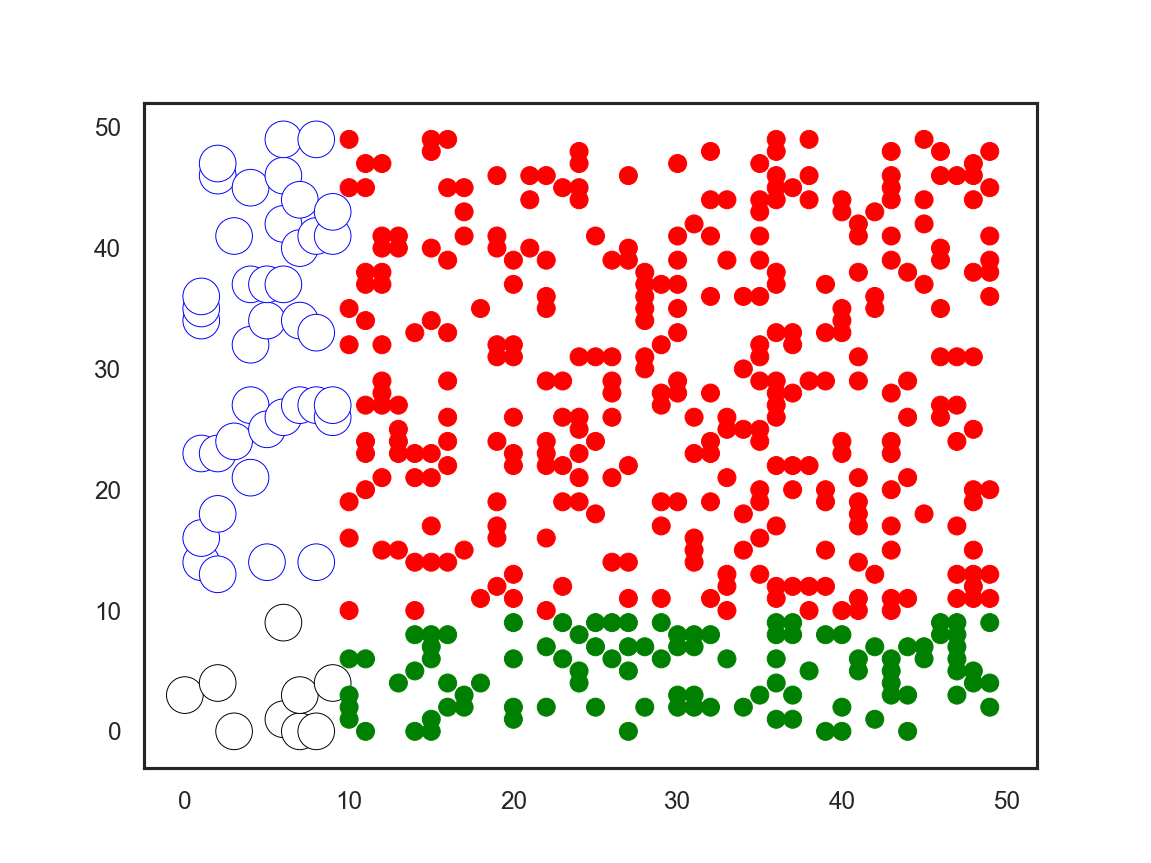

<IPython.core.display.Javascript object>


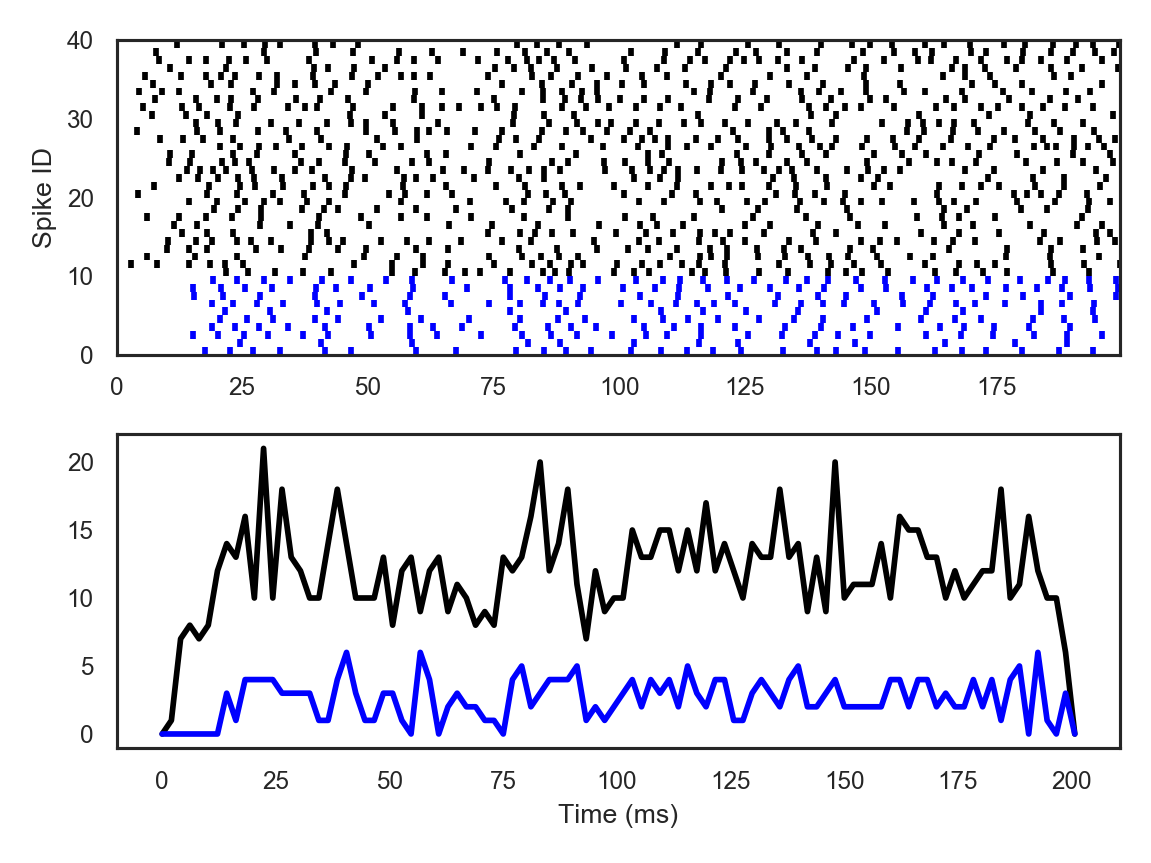

In [61]:
#### weights plot ####
f,ax = plt.subplots()
ax.scatter(SII.i, SII.j, 20*(np.abs(SII.w/nS) - .12), edgecolor='k',facecolor='w')# SII.w*20, 'k')
ax.scatter(SIE.i, SIE.j + nneuronsI, 20*(np.abs(SIE.w/nS) - .12), edgecolor='b', facecolor='w')#SIE.w*20, 'b')
ax.scatter(SEI.i+ nneuronsI, SEI.j, 20*(SEI.w/nS - .12), 'g')
ax.scatter(SEE.i+ nneuronsI, SEE.j+ nneuronsI, 20*(SEE.w/nS - .12), 'r')

#### Raster plot #####
plot_raster(ts, neur_ix, tsI, neur_ixI)

In [83]:
##### Export spikes to Matlab ####
fname='test_network.mat'
export_mat(fname, ts, neur_ix, tsI, neur_ixI, SII, SIE, SEI, SEE)

In [82]:
def export_mat(fname, tsE, neurE, tsI, neurI, SII, SIE, SEI, SEE): 
    
    mat_file = dict()
    mat_file['tsE'] = tsE
    mat_file['idE'] = neurE
    mat_file['tsI'] = tsI
    mat_file['idI'] = neurI
    
    ### Connectivity 
    for i_s, (S, Snm) in enumerate(zip([SII, SIE, SEI, SEE], ['SII', 'SIE', 'SEI', 'SEE'])):
        mat_file[Snm,'pre'] = np.array(S.i)
        mat_file[Snm,'post'] = np.array(S.j)
        mat_file[Snm, 'wt_nS'] = np.array(S.w)
    
    ### Save 
    sio.savemat(fname, mat_file)
        